In [24]:
import pandas as pd
# testing the subtract model
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from focal_loss import binary_focal_loss

In [25]:

class MaskedEmbedding(keras.layers.Layer):
    def __init__(self, mask_token=-1., pad_token=-2., name='masked_embedding'):
        super().__init__(name=name)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, x, mask):
        """
        Args:
            x: Input tensor of shape (B, N, D)
            mask: Tensor of shape (B, N)
        Returns:
            Tensor with masked positions set to zero.
        """
        mask = tf.cast(mask, tf.float32)
        mask = tf.where((mask == self.pad_token) | (mask == self.mask_token), 0., 1.)
        return x * mask[:, :, tf.newaxis]  # Apply mask to zero out positions


class PositionalEncoding(keras.layers.Layer):
    """
    Sinusoidal Positional Encoding layer that applies encodings
    only to non-masked tokens.

    Args:
        embed_dim (int): Dimension of embeddings (must match input last dim).
        max_len (int): Maximum sequence length expected (used to precompute encodings).
    """

    def __init__(self, embed_dim, pos_range=100, mask_token=-1., pad_token=-2., name='positional_encoding'):
        super().__init__(name=name)
        self.embed_dim = embed_dim
        self.pos_range = pos_range
        self.mask_token = mask_token
        self.pad_token = pad_token

    def build(self, x):
        # Create (1, pos_range, embed_dim) encoding matrix
        pos = tf.range(self.pos_range, dtype=tf.float32)[:, tf.newaxis]  # (pos_range, 1)
        i = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]  # (1, embed_dim)
        #angle_rates = 1 / tf.pow(300.0, (2 * (i // 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rates = tf.pow(300.0, -(2 * tf.floor(i / 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = pos * angle_rates  # (pos_range, embed_dim)

        # Apply sin to even indices, cos to odd indices
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)  # (max_len, embed_dim)
        pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, max_len, embed_dim)
        self.pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, mask):
        """
        Args:
            x: Input tensor of shape (B, N, D)
            mask: Tensor of shape (B,N)
        Returns:
            Tensor with positional encodings added for masked and non padded tokens.
        """
        seq_len = tf.shape(x)[1]
        pe = self.pos_encoding[:, :seq_len, :]  # (1, N, D)
        mask = tf.cast(mask[:, :, tf.newaxis], tf.float32)  # (B, N, 1)
        mask = tf.where(mask == self.pad_token, 0., 1.)
        pe = pe * mask  # zero out positions where mask is 0

        return x + pe

class SubtractLayer(keras.layers.Layer):
    """
    Custom layer to subtract a tensor from another tensor.
    Tensor1: (B, P, D) -> (B, P*D) -> (B, M, P*D)
    Tensor2: (B, M, D) -> (B, M, P*D)
    Output: = Tensor2 - Tensor1
    """
    def __init__(self, mask_token=-1., pad_token=-2., **kwargs):
        """Initialize the layer."""
        super(SubtractLayer, self).__init__(**kwargs)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, peptide, pep_mask, mhc, mhc_mask):
        B = tf.shape(peptide)[0]
        P = tf.shape(peptide)[1]
        D = tf.shape(peptide)[2]
        M = tf.shape(mhc)[1]
        P_D = P * D

        pep_mask = tf.cast(pep_mask, tf.float32)
        mhc_mask = tf.cast(mhc_mask, tf.float32)

        pep_mask = tf.where(pep_mask == self.pad_token, x=0., y=1.)  # (B,P)
        mhc_mask = tf.where(mhc_mask == self.pad_token, x=0., y=1.)

        # peptide  (B,P,D) -> (B,P*D) -> (B,M,P*D)
        peptide_flat = tf.reshape(peptide, (B, P_D))
        peptide_exp = tf.repeat(peptide_flat[:, tf.newaxis, :], repeats=M, axis=1)
        # mhc       (B,M,D) -> tile last axis P times -> (B,M,P*D)
        mhc_exp = tf.tile(mhc, [1, 1, P])
        result = mhc_exp - peptide_exp  # (B,M,P*D)
        # peptide mask  (B,P) -> (B,P,D) -> flatten -> (B,P*D) -> (B,M,P*D)
        pep_mask_PD = tf.tile(pep_mask[:, :, tf.newaxis], [1, 1, D])  # (B,P,D)
        pep_mask_PD = tf.reshape(pep_mask_PD, (B, P_D))  # (B,P*D)
        pep_mask_PD = tf.repeat(pep_mask_PD[:, tf.newaxis, :], repeats=M, axis=1)  # (B,M,P*D)
        # mhc mask      (B,M) -> (B,M,1) -> repeat P*D along last axis
        mhc_mask_PD = tf.repeat(mhc_mask[:, :, tf.newaxis], repeats=P_D, axis=2)  # (B,M,P*D)
        combined_mask = tf.logical_and(tf.cast(pep_mask_PD, tf.bool), tf.cast(mhc_mask_PD, tf.bool))
        masked_result = tf.where(combined_mask, result, tf.zeros_like(result))
        return masked_result

class AddGaussianNoise(layers.Layer):
    def __init__(self, std=0.1, **kw): super().__init__(**kw); self.std = std

    def call(self, x, training=None):
        if training: return x + tf.random.normal(tf.shape(x), stddev=self.std)
        return x

class AttentionLayer(keras.layers.Layer):
    """
    Custom multi-head attention layer supporting self- and cross-attention.

    Args:
        query_dim (int): Input feature dimension for query.
        context_dim (int): Input feature dimension for context (key and value).
        output_dim (int): Output feature dimension.
        type (str): 'self' or 'cross'.
        heads (int): Number of attention heads.
        resnet (bool): Whether to use residual connection.
        return_att_weights (bool): Whether to return attention weights.
        name (str): Layer name.
        epsilon (float): Epsilon for layer normalization.
        gate (bool): Whether to use gating mechanism.
        mask_token (float): Value for masked tokens.
        pad_token (float): Value for padded tokens.
    """
    def __init__(self, query_dim, context_dim, output_dim, type, heads=4,
                 resnet=True, return_att_weights=False, name='attention',
                 epsilon=1e-6, gate=True, mask_token=-1., pad_token=-2.):
        super().__init__(name=name)
        assert isinstance(query_dim, int) and isinstance(context_dim, int) and isinstance(output_dim, int)
        assert type in ['self', 'cross']
        if resnet:
            assert query_dim == output_dim
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.type = type
        self.heads = heads
        self.resnet = resnet
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.gate = gate
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head

    def build(self, input_shape):
        # Projection weights
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        if self.gate:
            self.g = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                     initializer='random_uniform', trainable=True, name=f'gate_{self.name}')
        self.norm = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_{self.name}')
        if self.type == 'cross':
            self.norm_context = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_context_{self.name}')
        self.norm_out = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_out_{self.name}')
        if self.resnet:
            self.norm_resnet = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln_resnet_{self.name}')
        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.float32))

    def call(self, x, mask, context=None, context_mask=None):
        """
        Args:
            x: Tensor of shape (B, N, query_dim) for query.
            mask: Tensor of shape (B, N).
            context: Tensor of shape (B, M, context_dim) for key/value in cross-attention.
            context_mask: Tensor of shape (B, M) for context.
        """
        mask = tf.cast(mask, tf.float32)
        if self.type == 'self':
            context = x
            context_mask = mask
            q_input = k_input = v_input = self.norm(x)
            mask_q = mask_k = tf.where(mask == self.pad_token, 0., 1.)
        else:
            assert context is not None and context_mask is not None
            q_input = self.norm(x)
            k_input = v_input = self.norm_context(context)
            mask_q = tf.where(mask == self.pad_token, 0., 1.)
            mask_k = tf.where(context_mask == self.pad_token, 0., 1.)

        # Project query, key, value
        q = tf.einsum('bnd,hde->bhne', q_input, self.q_proj)
        k = tf.einsum('bmd,hde->bhme', k_input, self.k_proj)
        v = tf.einsum('bmd,hde->bhme', v_input, self.v_proj)

        # Compute attention scores
        att = tf.einsum('bhne,bhme->bhnm', q, k) * self.scale
        mask_q_exp = tf.expand_dims(mask_q, axis=1)
        mask_k_exp = tf.expand_dims(mask_k, axis=1)
        attention_mask = tf.einsum('bqn,bkm->bqnm', mask_q_exp, mask_k_exp)
        attention_mask = tf.broadcast_to(attention_mask, tf.shape(att))
        att += (1.0 - attention_mask) * -1e9
        att = tf.nn.softmax(att, axis=-1) * attention_mask

        # Compute output
        out = tf.einsum('bhnm,bhme->bhne', att, v)
        if self.gate:
            g = tf.einsum('bnd,hde->bhne', q_input, self.g)
            g = tf.nn.sigmoid(g)
            out *= g

        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x)[0], tf.shape(x)[1], self.heads * self.att_dim])
        out = tf.matmul(out, self.out_w) + self.out_b

        if self.resnet:
            out += x
            out = self.norm_resnet(out)
        out = self.norm_out(out)
        mask_exp = tf.expand_dims(mask_q, axis=-1)
        out *= mask_exp

        return (out, att) if self.return_att_weights else out

In [26]:
# All you need to do, is to have one layer called EnhancedMixtureOfExperts. In this layer, you just need to define a gate, and a dense model.
# The self.gate_weight = self.add_weight(shape=(1, self.num_experts, self.input_dim, self.output_dim), trainable=True, initializer='random_uniform') and self.gate_bias(shape=(1, self.num_experts, 1, self.output_dim), trainable=True, initializer='zeros')
# and the same for your dense model. You should have a self.dense_weight() and a self.dense_bias with exactly the same dimension as gate.
# in call() you just need to do a tf.nn.softmax() on (tf.matmul(input, self.gate_weight) + self.gate_bias) over the experts axis
# Them multiply this with the output of matmul between input, self.dense_weight + self.dense_bias)
# For training, you convert softmax to hardmax and multiply it.
# That's it
# Simple

# class ExpertLayer(keras.layers.Layer):
#     """
#     Expert layer that applies a dense transformation to the input.
#
#     Args:
#         input_dim (int): Input dimension.
#         output_dim (int): Output dimension.
#         dropout_rate (float): Dropout rate.
#     """
#     def __init__(self, input_dim, output_dim, dropout_rate=0.2):
#         super(ExpertLayer, self).__init__()
#         self.w_init = tf.random_normal_initializer(stddev=0.1)
#         self.z_init = tf.zeros_initializer()
#         self.input_dim = input_dim
#         self.dense1 = keras.layers.Dense(
#             output_dim,
#             kernel_initializer=self.w_init,
#             bias_initializer=self.z_init,
#             name='expert_dense1'
#         )
#         self.dropout1 = keras.layers.Dropout(dropout_rate, name='expert_dropout1')
#         self.dense2 = keras.layers.Dense(
#             output_dim,
#             kernel_initializer=self.w_init,
#             bias_initializer=self.z_init,
#             name='expert_dense2'
#         )
#         self.dropout = keras.layers.Dropout(dropout_rate, name='expert_dropout2')
#
#     def call(self, x, training=False):
#         x = self.dense1(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.dense2(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = tf.nn.relu(x)  # Apply ReLU activation
#         return x
#
#
# class EnhancedMixtureOfExperts(keras.layers.Layer):
#     """
#     Enhanced Mixture of Experts layer that uses cluster assignments.
#
#     - During training: use hard clustering (vector) to route to a specific expert per sample
#     - During inference: use soft clustering to mix experts' weights per sample
#     """
#
#     def __init__(self, input_dim, hidden_dim=32, num_experts=16, output_dim=1, dropout_rate=0.2):
#         super(EnhancedMixtureOfExperts, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_experts = num_experts
#         self.output_dim = output_dim
#
#         self.gate_weight = self.add_weight(shape=(self.input_dim, self.input_dim, self.num_experts), trainable=True, initializer='random_uniform')
#         self.gate_bias = self.add_weight(shape=(self.input_dim, self.num_experts), trainable=True, initializer='zeros')
#
#         # self.dense_weight = self.add_weight(shape=(1, self.num_experts, self.input_dim, self.output_dim), trainable=True, initializer='random_uniform')
#         # self.dense_bias = self.add_weight(shape=(1, self.num_experts, 1, self.output_dim), trainable=True, initializer='zeros')
#
#         self.experts = [ExpertLayer(self.input_dim, self.output_dim, dropout_rate) for _ in range(self.num_experts)]
#
#     def hardmax(self, soft_clusters):
#         """
#         Convert soft clustering to hard clustering by selecting the max index.
#         Args:
#             soft_clusters: Tensor of shape (B, num_experts, output_dim).
#         Returns:
#             Hard clustering tensor of shape (B, num_experts, output_dim).
#         """
#         hard_indices = tf.argmax(soft_clusters, axis=1)
#         tf.print("Hard indices shape:", hard_indices.shape, "Hard indices:", hard_indices)
#         return hard_indices
#
#     def call(self, x_batch, training=False):
#         """
#         We have to generate a one-hot encoding that defines which expert is activated for each sample. (B, num_experts, ohe_num_experts).
#
#         Args:
#             x: Input tensor of shape (B, input_dim).
#             training: Whether the layer is in training mode.
#         Returns:
#             Output tensor of shape (B, output_dim).
#         """
#         # input shape
#         tf.print("Input shape:", x_batch.shape, "Training mode:", training) # (B, input_dim) for each sample we need a vector of size (num_experts, ) to activate corresponding experts
#
#         # Compute gate probabilities
#         gate_probs = tf.nn.softmax(tf.matmul(x_batch, self.gate_weight) + self.gate_bias)  # (B, num_experts)
#
#         if training:
#             # Convert to hard clustering for training
#             gate_probs = self.hardmax(gate_probs) # (B, num_experts)
#         else:
#             # Use soft clustering during inference
#             gate_probs = tf.nn.softmax(gate_probs) # (B, num_experts)
#             # ignore very low probabilities
#             gate_probs = tf.clip_by_value(gate_probs, clip_value_min=1e-6, clip_value_max=1.0)  # Avoid zero probabilities
#             tf.print("Gate probabilities shape:", gate_probs.shape, "Gate probabilities:", gate_probs)
#
#
#         out = tf.zeros((tf.shape(x_batch)[0], self.output_dim), dtype=tf.float32)  # Initialize output tensor
#         for i, gate in zip(range(self.num_experts), gate_probs):
#             if gate[i] > 0: # this means that the expert is active
#                 expert = self.experts[i]
#                 expert_output = expert(x_batch, training=training)  # (B, output_dim)
#                 out += gate[i] * expert_output  # Weighted sum of expert outputs
#
#         # normalize output by number of activated experts
#         num_active_experts = tf.reduce_sum(gate_probs, axis=1, keepdims=True)  # (B, 1)
#         num_active_experts = tf.clip_by_value(num_active_experts, clip_value_min=1e-6, clip_value_max=tf.reduce_max(num_active_experts))  # Avoid division by zero
#         output = out / num_active_experts  # Normalize by number of active experts
#
#         # use sigmoid activation for binary classification
#         output = tf.nn.sigmoid(output)  # (B, output_dim)
#
#         return output



# class ExpertLayer(keras.layers.Layer):
#     """
#     Args: input_dim (int): Input dimension. output_dim (int): Output dimension. dropout_rate (float): Dropout rate.
#      """
#     def __init__(self, output_dim, dropout_rate=0.2):
#         super(ExpertLayer, self).__init__()
#         self.w_init = tf.random_normal_initializer(stddev=0.1)
#         self.z_init = tf.zeros_initializer()
#         self.dense1 = keras.layers.Dense( output_dim, kernel_initializer=self.w_init, bias_initializer=self.z_init, name='expert_dense1' )
#         self.dropout1 = keras.layers.Dropout(dropout_rate, name='expert_dropout1')
#         self.dense2 = keras.layers.Dense( output_dim, kernel_initializer=self.w_init, bias_initializer=self.z_init, name='expert_dense2' )
#         self.dropout2 = keras.layers.Dropout(dropout_rate, name='expert_dropout2')
#
#     def call(self, x, training=False):
#         x = self.dense1(x)
#         if training:
#             x = self.dropout1(x, training=training)
#         x = self.dense2(x)
#         if training:
#             x = self.dropout2(x, training=training)
#         x = tf.nn.relu(x) # Apply ReLU activation return x
#         return x
#
#
# class EnhancedMixtureOfExperts(keras.layers.Layer):
#     """ Enhanced Mixture of Experts layer that uses cluster assignments.
# - During training: use hard clustering (vector) to route to a specific expert per sample
# - During inference: use soft clustering to mix experts' weights per sample
# """
#
#     def __init__(self, input_dim, hidden_dim, num_experts=16, output_dim=1, dropout_rate=0.2):
#         super(EnhancedMixtureOfExperts, self).__init__()
#         self.input_dim = input_dim
#         self.num_experts = num_experts
#         self.output_dim = output_dim
#
#         # Gating network weights
#         self.gate_weight = self.add_weight(shape=(self.input_dim, self.num_experts), trainable=True, initializer='random_uniform', name='gate_weight')
#         self.gate_bias = self.add_weight(shape=(self.num_experts,), trainable=True, initializer='zeros', name='gate_bias')
#
#         # Expert networks
#         self.experts = [ExpertLayer(self.output_dim, dropout_rate) for i in range(self.num_experts)]
#
#     def hardmax(self, logits):
#         """
#         Convert logits to a one-hot tensor by selecting the max index.
#         Args:
#             logits: Tensor of shape (B, num_experts).
#         Returns:
#             Hard assignment tensor of shape (B, num_experts).
#         """
#         hard_indices = tf.argmax(logits, axis=1)
#         return tf.one_hot(hard_indices, depth=self.num_experts, dtype=tf.float32)
#
#     def call(self, x_batch, training=False):
#         """
#         Args:
#             x_batch: Input tensor of shape (B, input_dim).
#             training: Whether the layer is in training mode.
#         Returns:
#             Output tensor of shape (B, output_dim).
#         """
#         # Compute gating logits
#         gate_logits = tf.matmul(x_batch, self.gate_weight) + self.gate_bias  # (B, num_experts)
#
#         if training:
#             # Use hardmax for routing during training
#             gate_probs = self.hardmax(gate_logits)  # (B, num_experts), one-hot
#         else:
#             # Use softmax for soft mixing during inference
#             gate_probs = tf.nn.softmax(gate_logits, axis=-1)  # (B, num_experts)
#
#         # Get expert outputs
#         expert_outputs = tf.stack([expert(x_batch, training=training) for expert in self.experts], axis=1)  # (B, num_experts, output_dim)
#
#         # Weight expert outputs by gate probabilities
#         # gate_probs (B, E), expert_outputs (B, E, D) -> output (B, D)
#         # We need to expand gate_probs to (B, E, 1) for broadcasting
#         weighted_outputs = gate_probs[:, :, tf.newaxis] * expert_outputs
#
#         # Sum the weighted outputs
#         output = tf.reduce_sum(weighted_outputs, axis=1) # (B, output_dim)
#
#         return output

class ExpertLayer(keras.layers.Layer):
    """
    Expert layer that applies a dense transformation to the input.

    Args:
        input_dim (int): Input dimension.
        hidden_dim (int): Hidden dimension.
        output_dim (int): Output dimension.
        dropout_rate (float): Dropout rate.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(ExpertLayer, self).__init__()
        self.w_init = tf.random_normal_initializer(stddev=0.1)
        self.z_init = tf.zeros_initializer()
        self.input_dim = input_dim
        self.dense1 = keras.layers.Dense(
            hidden_dim,  # Changed from output_dim to hidden_dim
            kernel_initializer=self.w_init,
            bias_initializer=self.z_init,
            name='expert_dense1'
        )
        self.dropout1 = keras.layers.Dropout(dropout_rate, name='expert_dropout1')
        self.dense2 = keras.layers.Dense(
            output_dim,  # Keep as output_dim
            kernel_initializer=self.w_init,
            bias_initializer=self.z_init,
            name='expert_dense2'
        )
        self.dropout = keras.layers.Dropout(dropout_rate, name='expert_dropout2')

    def call(self, x, training=False):
        x = self.dense1(x)
        x = tf.nn.relu(x)  # Apply ReLU activation after first layer
        if training:
            x = self.dropout1(x, training=training)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        # Removed final ReLU to allow negative outputs before sigmoid
        return x


class EnhancedMixtureOfExperts(keras.layers.Layer):
    """
    Enhanced Mixture of Experts layer that uses cluster assignments.

    - During training: use hard clustering (vector) to route to a specific expert per sample
    - During inference: use soft clustering to mix experts' weights per sample
    """

    def __init__(self, input_dim, hidden_dim=32, num_experts=16, output_dim=1, dropout_rate=0.2):
        super(EnhancedMixtureOfExperts, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_experts = num_experts
        self.output_dim = output_dim

        self.experts = [ExpertLayer(self.input_dim, self.hidden_dim, self.output_dim, dropout_rate) for _ in range(self.num_experts)]

    def hardmax(self, soft_clusters):
        """
        Convert soft clustering to hard clustering by selecting the max index.
        Args:
            soft_clusters: Tensor of shape (B, num_experts).
        Returns:
            Hard clustering tensor of shape (B, num_experts).
        """
        hard_indices = tf.argmax(soft_clusters, axis=-1)
        hard_clusters = tf.one_hot(hard_indices, depth=self.num_experts, dtype=tf.float32)
        return hard_clusters

    def call(self, inputs, training=False):
        """
        We have to generate a one-hot encoding that defines which expert is activated for each sample. (B, num_experts, ohe_num_experts).

        Args:
            x: Input tensor of shape (B, input_dim).
            training: Whether the layer is in training mode.
        Returns:
            Output tensor of shape (B, output_dim).
        """
        x_batch, gate_probs = inputs
        if training:
            gate_probs = self.hardmax(gate_probs)
        else:
            gate_probs = tf.clip_by_value(gate_probs, clip_value_min=1e-6, clip_value_max=1.0)  # Avoid zero probabilities

        # tf.print("Gate probabilities shape:", gate_probs.shape, "Gate probabilities:", gate_probs)

        out = tf.zeros((tf.shape(x_batch)[0], self.output_dim), dtype=tf.float32)  # Initialize output tensor
        for i in range(self.num_experts):
            gate = gate_probs[:, i]
            expert = self.experts[i]
            expert_output = expert(x_batch, training=training)  # (B, output_dim)
            out += tf.expand_dims(gate, axis=-1) * expert_output  # Weighted sum of expert outputs

        output = tf.nn.sigmoid(out)  # (B, output_dim)

        return output



# --- Example usage ---
# --- Dummy Training Example ---

# 1. Hyperparameters
input_dim = 10
num_experts = 4
output_dim = 1
num_samples = 500
batch_size = 16
epochs = 3

# Generate dummy data
x_train = tf.random.normal((num_samples, input_dim))
y_train = tf.random.uniform((num_samples, 1), maxval=2, dtype=tf.int32)
gate_probs = tf.random.uniform((num_samples, num_experts), minval=0, maxval=1, dtype=tf.float32)
gate_probs = gate_probs / tf.reduce_sum(gate_probs, axis=1, keepdims=True)
y_train = tf.cast(y_train, tf.float32)

# Build model
x_in = tf.keras.Input(shape=(input_dim,), name="features")
gate_in = tf.keras.Input(shape=(num_experts,), name="gate_probs")
moe_layer = EnhancedMixtureOfExperts(input_dim=input_dim,
                                     hidden_dim=32,
                                     num_experts=num_experts,
                                     output_dim=output_dim)
moe_output = moe_layer((x_in, gate_in), training=True)

model = tf.keras.Model(inputs=[x_in, gate_in], outputs=moe_output)
# Compile model
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Compile and train model
model.fit([x_train, gate_probs], y_train, batch_size=batch_size, epochs=epochs)


# validate
x_val = tf.random.normal((100, input_dim))
gate_probs_val = tf.random.uniform((100, num_experts), minval=0, maxval=1, dtype=tf.float32)
gate_probs_val = gate_probs_val / tf.reduce_sum(gate_probs_val, axis=1, keepdims=True)
y_val = tf.random.uniform((100, 1), maxval=2, dtype=tf.int32)
y_val = tf.cast(y_val, tf.float32)
val_loss, val_acc = model.evaluate([x_val, gate_probs_val], y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")



Epoch 1/3
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]]
 1/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5000 - loss: 0.7088Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]]
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]]
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]]
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]]
Gate probabilities shape: TensorShape([None, 4]) Gate probabilities: [[0

In [27]:
# def masked_categorical_crossentropy(y_true_y_pred, mask, pad_token=-2.0):
#     """
#     Compute masked categorical cross-entropy loss.
#
#     Args:
#         y_true: True labels (tensor).
#         y_pred: Predicted probabilities (tensor).
#         mask: Mask tensor indicating positions to include in the loss.
#
#     Returns:
#         Mean masked loss (tensor).
#     """
#     y_true, y_pred = tf.split(y_true_y_pred, num_or_size_splits=2, axis=-1)
#     # loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     loss = -tf.reduce_sum(y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0)), axis=-1) #(B,N)
#     mask = tf.cast(mask, tf.float32)  # Ensure mask is float
#     mask = tf.where(mask == pad_token, 0.0, 1.0)  # Convert pad token to 0.0 and others to 1.0
#     if tf.rank(mask) > tf.rank(loss):
#         mask = tf.squeeze(mask, axis=-1)
#     loss = loss * mask
#     loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
#     return loss

def masked_categorical_crossentropy(y_true_and_pred, mask, pad_token=-2.0, sample_weight=None):
    """
    Compute masked categorical cross-entropy loss.

    Args:
        y_true_and_pred: Concatenated tensor of true labels and predictions.
        mask: Mask tensor indicating positions to include in the loss.
        pad_token: Value of the padding token in the mask.
        sample_weight: Optional tensor of shape (B, 1) or (B,) to weight samples.

    Returns:
        Mean masked loss (tensor).
    """
    y_true, y_pred = tf.split(y_true_and_pred, num_or_size_splits=2, axis=-1)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)  # (B, N)

    # Build a 0/1 mask for non-pad tokens
    mask = tf.cast(tf.not_equal(mask, pad_token), tf.float32)

    # If mask has an extra trailing dim of 1, squeeze it (static check only)
    if mask.shape.rank is not None and mask.shape.rank > 2 and mask.shape[-1] == 1:
        mask = tf.squeeze(mask, axis=-1)

    # Ensure shape compatibility with loss
    mask = tf.cast(tf.broadcast_to(mask, tf.shape(loss)), tf.float32)

    masked_loss = loss * mask

    # Apply sample weights if provided
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, tf.float32)
        if sample_weight.shape.rank == 2 and sample_weight.shape[1] == 1:
            sample_weight = tf.squeeze(sample_weight, axis=-1) # (B,)
        # Broadcast sample_weight from (B,) to (B, N) to match masked_loss
        masked_loss *= sample_weight[:, tf.newaxis]
        mask *= sample_weight[:, tf.newaxis]

    total_loss = tf.reduce_sum(masked_loss)
    total_weight = tf.reduce_sum(mask)
    return tf.math.divide_no_nan(total_loss, total_weight)

class GlobalAveragePooling1D(layers.Layer):
    """
    Global Average Pooling layer that computes the mean across the sequence dimension for each feature.
    Args:
        name (str): Layer name.
    """
    def __init__(self, name='global_avg_pooling'):
        super().__init__(name=name)

    def call(self, input_tensor):
        """
        Args:
            inputs: Input tensor of shape (B, N, D).
        Returns:
            Tensor of shape (B, N) containing the mean across D.
        """
        pooled_avg = tf.math.reduce_mean(
            input_tensor, axis=1, keepdims=False
            )
        return pooled_avg

class GlobalSTDPooling1D(layers.Layer):
    """
    Global Standard Deviation Pooling layer that computes the standard deviation
    across the sequence dimension for each feature.
    Args:
        name (str): Layer name.
    """
    def __init__(self, name='global_std_pooling'):
        super().__init__(name=name)

    def call(self, input_tensor):
        """
        Args:
            inputs: Input tensor of shape (B, N, D).
        Returns:
            Tensor of shape (B, N) containing the standard deviation across D.
        """
        pooled_std = tf.math.reduce_std(
            input_tensor, axis=1, keepdims=False, name=None
            )
        return pooled_std


In [29]:
# model
from tensorflow.keras import layers
MASK_TOKEN = -1.0
PAD_TOKEN = -2.0


def pmbind_subtract_moe_auto(max_pep_len: int,
                               max_mhc_len: int,
                               emb_dim: int = 96,
                               heads: int = 4,
                               noise_std: float = 0.1,
                               num_experts: int = 30,
                               mask_token: float = MASK_TOKEN,
                               pad_token: float = PAD_TOKEN):
    """
    Builds a pMHC autoencoder model with a Mixture-of-Experts (MoE) classifier head.

    This model performs two tasks:
    1. Autoencoding: Reconstructs peptide and MHC sequences from a latent representation.
    2. Classification: Predicts a binary label using an MoE head, where experts are
       selected based on an internally generated clustering of the latent space.
    """
    # -------------------------------------------------------------------
    # INPUTS
    # -------------------------------------------------------------------
    pep_OHE_in = keras.Input((max_pep_len, 21), name="pep_onehot")
    pep_mask_in = keras.Input((max_pep_len,), name="pep_mask")
    mhc_emb_in = keras.Input((max_mhc_len, 1152), name="mhc_emb")
    mhc_mask_in = keras.Input((max_mhc_len,), name="mhc_mask")
    mhc_OHE_in = keras.Input((max_mhc_len, 21), name="mhc_onehot")
    # -------------------------------------------------------------------
    # MASKED  EMBEDDING  +  PE
    # -------------------------------------------------------------------
    pep = MaskedEmbedding(mask_token, pad_token, name="pep_mask2")(pep_OHE_in, pep_mask_in)
    pep = PositionalEncoding(21, int(max_pep_len * 3), name="pep_pos1")(pep, pep_mask_in)
    pep = layers.Dense(emb_dim, name="pep_Dense1")(pep)
    pep = layers.Dropout(0.1, name="pep_Dropout1")(pep)

    mhc = MaskedEmbedding(mask_token, pad_token, name="mhc_mask2")(mhc_emb_in, mhc_mask_in)
    mhc = PositionalEncoding(1152, int(max_mhc_len * 3), name="mhc_pos1")(mhc, mhc_mask_in)
    mhc = layers.Dense(emb_dim, name="mhc_dense1")(mhc)
    mhc = layers.Dropout(0.1, name="mhc_Dropout1")(mhc)
    # -------------------------------------------------------------------
    # Subtract Layer
    # -------------------------------------------------------------------
    mhc_subtracted_p = SubtractLayer(name="pmhc_subtract")(pep, pep_mask_in, mhc, mhc_mask_in) # (B, M, P*D) = mhc_expanded – peptide_expanded
    #tf.print("mhc_subtracted_p shape:", mhc_subtracted_p.shape)
    # -------------------------------------------------------------------
    # Add Gaussian Noise
    # -------------------------------------------------------------------
    mhc_subtracted_p = AddGaussianNoise(noise_std, name="pmhc_gaussian_noise")(mhc_subtracted_p)
    query_dim = int(emb_dim*max_pep_len)
    # # -------------------------------------------------------------------
    # Normal Self-Attention Layer
    # # -------------------------------------------------------------------
    mhc_subtracted_p_attn, mhc_subtracted_p_attn_scores = AttentionLayer(
        query_dim=query_dim, context_dim=query_dim, output_dim=query_dim,
        type="self", heads=heads, resnet=True,
        return_att_weights=True, name='mhc_subtracted_p_attn',
        mask_token=mask_token,
        pad_token=pad_token
    )(mhc_subtracted_p, mhc_mask_in)
    peptide_cross_att, peptide_cross_attn_scores = AttentionLayer(
        query_dim=int(emb_dim), context_dim=query_dim, output_dim=int(emb_dim),
        type="cross", heads=heads, resnet=False,
        return_att_weights=True, name='peptide_cross_att',
        mask_token=mask_token,
        pad_token=pad_token
    )(pep, pep_mask_in, mhc_subtracted_p_attn, mhc_mask_in)

    # --- Encoder ---
    latent_sequence = layers.Dense(emb_dim*max_pep_len * 2, activation='relu', name='latent_mhc_dense1')(mhc_subtracted_p_attn)
    latent_sequence = layers.Dropout(0.2, name='latent_mhc_dropout1')(latent_sequence)
    latent_sequence = layers.Dense(emb_dim, activation='relu', name='cross_latent')(latent_sequence) # Shape: (B, M, D)

    # --- Latent Vector for Clustering (pooled) ---
    avg_pooled = GlobalAveragePooling1D(name="avg_pooled")(peptide_cross_att) # Shape: (B, D)
    std_pooled = GlobalSTDPooling1D(name="std_pooled")(peptide_cross_att) # Shape: (B, D)
    latent_vector = layers.Concatenate(name="latent_vector_concat", axis=-1)([avg_pooled, std_pooled])  # Shape: (B, D*2)

    # --- Reconstruction Heads ---
    mhc_recon_head = layers.Dropout(0.2, name='latent_mhc_dropout2')(latent_sequence)
    mhc_recon = layers.Dense(21, activation='softmax', name='mhc_reconstruction_pred')(mhc_recon_head)
    pep_recon = layers.Dense(emb_dim, activation='relu', name='pep_latent')(peptide_cross_att)
    pep_recon = layers.Dense(21, activation='softmax', name='pep_reconstruction_pred')(pep_recon)

    pep_out = layers.Concatenate(name='pep_ytrue_ypred', axis=-1)([pep_OHE_in, pep_recon]) #(B,P,42)
    mhc_out = layers.Concatenate(name='mhc_ytrue_ypred', axis=-1)([mhc_OHE_in, mhc_recon]) #(B,M,42)

    # -------------------------------------------------------------------
    # CLASSIFIER HEAD (MIXTURE OF EXPERTS)
    # -------------------------------------------------------------------
    # 1. Gating network: Generate soft cluster assignments from the latent vector
    bigger_probs = layers.Dense(num_experts * 2, activation='relu', name='gating_network_dense1')(latent_vector)
    bigger_probs = layers.Dropout(0.2, name='gating_network_dropout1')(bigger_probs)
    logits = layers.Dense(num_experts, name='gating_network_logits')(bigger_probs)
    soft_cluster_probs = layers.Softmax(axis=-1, name='gating_network_softmax')(logits) # Shape: (B, num_experts)

    # 2. MoE layer: Get weighted prediction from experts
    moe_layer = EnhancedMixtureOfExperts(
        input_dim=emb_dim*2,
        hidden_dim=emb_dim // 2,
        num_experts=num_experts,
        output_dim=1,
        dropout_rate=0.2
    )
    y_pred = moe_layer((latent_vector, soft_cluster_probs)) # (B, 1)

    # -------------------------------------------------------------------
    # MODEL DEFINITION
    # -------------------------------------------------------------------
    model = keras.Model(
        inputs=[pep_OHE_in, pep_mask_in, mhc_emb_in, mhc_mask_in, mhc_OHE_in],
        outputs={
            "pep_ytrue_ypred": pep_out,
            "mhc_ytrue_ypred": mhc_out,
            "latent_vector": latent_vector,
            "soft_cluster_probs": soft_cluster_probs,
            "cls_ypred": y_pred,
        },
        name="pmbind_subtract_moe_autoencoder"
    )

    return model

In [30]:
# ==============================================================================
# 3. DUMMY DATA GENERATION (for a runnable example)
# ==============================================================================
# Reproducible, structured synthetic dataset with correlated labels
np.random.seed(42)
tf.random.set_seed(42)

num_samples = 2000
pep_len = 14                  # max peptide length
mhc_len = 312
pep_alphabet_size = 21        # 20 AA + gap/UNK
mhc_embedding_dim = 1152

# 1) Peptide sequences with variable lengths (8..14), realistic AA frequencies, and masks
aa_probs = np.array([
    0.0825, 0.0150, 0.0545, 0.0685, 0.0395, 0.0705, 0.0225, 0.0590, 0.0900, 0.0150,
    0.0600, 0.0240, 0.0400, 0.0380, 0.0470, 0.0560, 0.0510, 0.0730, 0.0130, 0.0320,
    0.0020  # gap/UNK rare
], dtype=np.float32)
aa_probs = aa_probs / aa_probs.sum()

pep_lengths = np.random.randint(8, pep_len + 1, size=(num_samples,))
pep_indices = np.full((num_samples, pep_len), fill_value=20, dtype=np.int32)  # init with gap
pep_mask_np = np.full((num_samples, pep_len), fill_value=-2.0, dtype=np.float32)  # pad_token

for i in range(num_samples):
    L = pep_lengths[i]
    pep_indices[i, :L] = np.random.choice(pep_alphabet_size, size=L, p=aa_probs)
    pep_mask_np[i, :L] = 1.0
    # randomly mask up to 2 tokens within valid region
    num_masked = np.random.randint(0, 3)
    if num_masked > 0 and L > 0:
        mask_pos = np.random.choice(L, size=num_masked, replace=False)
        pep_mask_np[i, mask_pos] = -1.0  # mask_token

pep_OHE = tf.one_hot(pep_indices, depth=pep_alphabet_size, dtype=tf.float32)
pep_mask = tf.constant(pep_mask_np, dtype=tf.float32)

# 2) MHC embeddings with allele structure + MHC OHE with allele-specific residue distributions
num_alleles = 6
allele_ids = np.random.randint(0, num_alleles, size=(num_samples, 1)).astype(np.int32)

# allele base vectors and biases to induce signal
allele_base = np.random.normal(0, 1.0, size=(num_alleles, mhc_embedding_dim)).astype(np.float32)
allele_bias = np.random.normal(0, 0.5, size=(num_alleles,)).astype(np.float32)

# allele-specific residue distributions (Dirichlet)
residue_dir = 2.0 * np.ones((num_alleles, pep_alphabet_size), dtype=np.float32)
allele_res_probs = np.random.dirichlet(alpha=residue_dir[0], size=1)[0]
allele_res_probs = np.vstack([
    np.random.dirichlet(alpha=residue_dir[k]) for k in range(num_alleles)
]).astype(np.float32)

# build MHC embeddings and OHE indices
mhc_emb_np = np.zeros((num_samples, mhc_len, mhc_embedding_dim), dtype=np.float32)
mhc_indices = np.zeros((num_samples, mhc_len), dtype=np.int32)

for i in range(num_samples):
    a = allele_ids[i, 0]
    base_vec = allele_base[a]  # (D,)
    # per-position small noise around allele base
    mhc_emb_np[i] = base_vec[None, :] + 0.1 * np.random.normal(0, 1.0, size=(mhc_len, mhc_embedding_dim)).astype(np.float32)
    # residue per-position following allele-specific distribution
    mhc_indices[i] = np.random.choice(pep_alphabet_size, size=mhc_len, p=allele_res_probs[a])

mhc_emb = tf.constant(mhc_emb_np, dtype=tf.float32)
mhc_OHE = tf.one_hot(mhc_indices, depth=pep_alphabet_size, dtype=tf.float32)

# 3) MHC mask: trailing padding (0..10)
pad_token = -2.0
mask_token = -1.0
mhc_mask_np = np.ones((num_samples, mhc_len), dtype=np.float32)
for i in range(num_samples):
    num_padded = np.random.randint(0, 11)
    if num_padded > 0:
        mhc_mask_np[i, -num_padded:] = pad_token
mhc_mask = tf.constant(mhc_mask_np, dtype=tf.float32)

# 4) Zero out masked/padded positions in inputs
pep_bool_mask = tf.cast(pep_mask > 0, dtype=tf.float32)
mhc_bool_mask = tf.cast(mhc_mask > 0, dtype=tf.float32)
pep_OHE = pep_OHE * pep_bool_mask[:, :, tf.newaxis]
mhc_emb = mhc_emb * mhc_bool_mask[:, :, tf.newaxis]

# 5) Create labels correlated with peptide and MHC embeddings
latent_dim = 32
Wp = tf.random.normal((pep_alphabet_size, latent_dim), stddev=0.5)
Wm = tf.random.normal((mhc_embedding_dim, latent_dim), stddev=0.1)

# pooled peptide feature
pep_feat = tf.tensordot(pep_OHE, Wp, axes=[[2], [0]])                      # (B, P, Ld)
pep_valid = pep_bool_mask[:, :, None]                                      # (B, P, 1)
pep_pool = tf.math.divide_no_nan(tf.reduce_sum(pep_feat * pep_valid, axis=1),
                                 tf.reduce_sum(pep_valid, axis=1))         # (B, Ld)

# pooled MHC feature
mhc_feat = tf.tensordot(mhc_emb, Wm, axes=[[2], [0]])                      # (B, M, Ld)
mhc_valid = mhc_bool_mask[:, :, None]                                      # (B, M, 1)
mhc_pool = tf.math.divide_no_nan(tf.reduce_sum(mhc_feat * mhc_valid, axis=1),
                                 tf.reduce_sum(mhc_valid, axis=1))         # (B, Ld)

# interaction + allele bias -> probability -> labels
interaction = tf.reduce_sum(pep_pool * mhc_pool, axis=1, keepdims=True)    # (B,1)
allele_bias_tf = tf.constant(allele_bias, dtype=tf.float32)
allele_ids_tf = tf.constant(allele_ids, dtype=tf.int32)
bias_term = tf.gather(allele_bias_tf, tf.squeeze(allele_ids_tf, axis=1))[:, None]
logits = interaction + bias_term + tf.random.normal((num_samples, 1), stddev=0.3)
probs = tf.sigmoid(logits)
y_true = tf.cast(tf.random.uniform((num_samples, 1)) < probs, tf.float32)

# 5b) Introduce a slight pattern shift for negative samples
neg_mask = tf.squeeze(1.0 - y_true, axis=1)                      # (B,)
neg_mask_3d = neg_mask[:, None, None]                            # (B,1,1)

# Add a small sinusoidal pattern to MHC embeddings of negatives
pattern = tf.sin(tf.linspace(0.0, tf.constant(2.0 * np.pi, dtype=tf.float32), mhc_embedding_dim))
pattern = tf.reshape(pattern, (1, 1, mhc_embedding_dim))         # (1,1,D)
mhc_emb = mhc_emb + 0.05 * neg_mask_3d * pattern

# Softly bias MHC OHE towards a fixed residue for negatives (soft labels)
alpha = 0.05
bias_residue = tf.one_hot(3, depth=pep_alphabet_size, dtype=tf.float32)     # choose residue index 3 as bias
bias_dist = tf.reshape(bias_residue, (1, 1, pep_alphabet_size))             # (1,1,21)
mhc_OHE = (1.0 - alpha * neg_mask_3d) * mhc_OHE + (alpha * neg_mask_3d) * bias_dist

# Re-apply masks to keep padded/invalid positions zeroed
mhc_emb = mhc_emb * mhc_bool_mask[:, :, None]
mhc_OHE = mhc_OHE * mhc_bool_mask[:, :, None]
pep_OHE = pep_OHE * pep_bool_mask[:, :, None]

# 6) Group inputs/targets (autoencoder targets are placeholders; recon losses use predictions)
inputs = {
    "pep_onehot": pep_OHE,
    "pep_mask": pep_mask,
    "mhc_emb": mhc_emb,
    "mhc_mask": mhc_mask,
    "mhc_onehot": mhc_OHE
}
targets = {
    "pep_ytrue_ypred": pep_OHE,
    "mhc_ytrue_ypred": mhc_OHE,
    "cls_ypred": y_true
}

In [31]:
# # Constants
# AA = "ACDEFGHIKLMNPQRSTVWY-"
# AA_TO_INT = {a: i for i, a in enumerate(AA)}
# UNK_IDX = 20  # Index for "unknown"
# MASK_TOKEN = -1.0
# NORM_TOKEN = 1.0
# PAD_TOKEN = -2.0
# PAD_VALUE = 0.0
# MASK_VALUE = 0.0
#
#
# def seq_to_onehot(sequence: str, max_seq_len: int) -> np.ndarray:
#     """Convert peptide sequence to one-hot encoding"""
#     arr = np.full((max_seq_len, 21), PAD_VALUE, dtype=np.float32) # initialize padding with 0
#     for j, aa in enumerate(sequence.upper()[:max_seq_len]):
#         arr[j, AA_TO_INT.get(aa, UNK_IDX)] = 1.0
#         # print number of UNKs in the sequence
#     # num_unks = np.sum(arr[:, UNK_IDX])
#     # zero out gaps
#     arr[:, AA_TO_INT['-']] = PAD_VALUE  # Set gaps to PAD_VALUE
#     # if num_unks > 0:
#     #     print(f"Warning: {num_unks} unknown amino acids in sequence '{sequence}'")
#     return arr

In [32]:

# ==============================================================================
# 4. CUSTOM TRAINING LOOP SETUP
# ==============================================================================
# --- Hyperparameters and Setup ---
epochs = 15
batch_size = 128
learning_rate = 1e-3
emb_dim = 21
heads = 4
noise_std = 0.1
num_experts = 16

# --- Instantiate Model, Optimizer, and Loss ---
model = pmbind_subtract_moe_auto(
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    emb_dim=emb_dim,
    heads=heads,
    noise_std=noise_std,
    num_experts=num_experts,
    mask_token=MASK_TOKEN,
    pad_token=PAD_TOKEN
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
binary_loss_fn = binary_focal_loss

# compile the model
# model.compile(
#     optimizer=optimizer,
#     loss={
#         "pep_ytrue_ypred": masked_categorical_crossentropy,
#         "mhc_ytrue_ypred": masked_categorical_crossentropy,
#         "cls_ypred": binary_loss_fn
#     },
# )

# --- Metrics for Tracking ---
metrics_names = ['loss', 'pep_recon_loss', 'mhc_recon_loss', 'class_loss', 'auc']
train_metrics = {name: tf.keras.metrics.Mean(name=f"train_{name}") for name in metrics_names}
val_metrics = {name: tf.keras.metrics.Mean(name=f"val_{name}") for name in metrics_names}
train_metrics['auc'] = tf.keras.metrics.AUC(name='train_auc')
val_metrics['auc'] = tf.keras.metrics.AUC(name='val_auc')

# --- Prepare tf.data.Dataset for efficient training ---
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(num_samples)
val_size = int(0.2 * num_samples)
train_dataset = dataset.skip(val_size).batch(batch_size, drop_remainder=True)
val_dataset = dataset.take(val_size).batch(batch_size, drop_remainder=True)


# print model stats
model.summary()

# ==============================================================================
# 5. TRAIN AND VALIDATION STEPS (using tf.function for performance)
# ==============================================================================
@tf.function
def train_step(x_batch, y_batch):
    x_batch_list = [x_batch['pep_onehot'], x_batch['pep_mask'], x_batch['mhc_emb'], x_batch['mhc_mask'], x_batch['mhc_onehot']]

    with tf.GradientTape() as tape:
        predictions = model(x_batch_list, training=True)
        # Calculate individual losses
        pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'], x_batch['pep_mask'], PAD_TOKEN,
                                                    sample_weight=y_batch['cls_ypred'])
        mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'], x_batch['mhc_mask'], PAD_TOKEN,
                                                   sample_weight=y_batch['cls_ypred'])
        class_loss = binary_loss_fn(y_batch['cls_ypred'], predictions['cls_ypred'], gamma=2.0, pos_weight=1.0, label_smoothing=0.1) # TODO wighted, emphasize on positive labels # FOCAL loss

        # Combine losses (you can apply weights here, e.g., total_loss = 0.5*pep_loss + ...)
        total_loss = pep_loss + mhc_loss + class_loss

    # Apply gradients
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update metrics
    train_metrics['loss'](total_loss)
    train_metrics['pep_recon_loss'](pep_loss)
    train_metrics['mhc_recon_loss'](mhc_loss)
    train_metrics['class_loss'](class_loss)
    train_metrics['auc'](y_batch['cls_ypred'], predictions['cls_ypred'])

@tf.function
def val_step(x_batch, y_batch):
    x_batch_list = [x_batch['pep_onehot'], x_batch['pep_mask'], x_batch['mhc_emb'], x_batch['mhc_mask'], x_batch['mhc_onehot']]

    predictions = model(x_batch_list, training=False)
    # Calculate losses
    pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'], x_batch['pep_mask'], PAD_TOKEN)
    mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'], x_batch['mhc_mask'], PAD_TOKEN)
    class_loss = binary_loss_fn(y_batch['cls_ypred'], predictions['cls_ypred'], gamma=2.0, pos_weight=1.0, label_smoothing=0.1) # FOCAL loss
    total_loss = pep_loss + mhc_loss + class_loss

    # Update metrics
    val_metrics['loss'](total_loss)
    val_metrics['pep_recon_loss'](pep_loss)
    val_metrics['mhc_recon_loss'](mhc_loss)
    val_metrics['class_loss'](class_loss)
    val_metrics['auc'](y_batch['cls_ypred'], predictions['cls_ypred'])

# ==============================================================================
# 6. THE MAIN TRAINING LOOP
# ==============================================================================
history = {f"{key}": [] for key in train_metrics.keys()}
history.update({f"val_{key}": [] for key in val_metrics.keys()})

print("Starting training...")
for epoch in range(epochs):
    # Reset metrics at the start of each epoch
    for metric in train_metrics.values(): metric.reset_state()
    for metric in val_metrics.values(): metric.reset_state()

    # Training loop
    for x_batch, y_batch in train_dataset:
        train_step(x_batch, y_batch)

    # Validation loop
    for x_val_batch, y_val_batch in val_dataset:
        val_step(x_val_batch, y_val_batch)

    # Log results
    train_results = {key: value.result().numpy() for key, value in train_metrics.items()}
    val_results = {key: value.result().numpy() for key, value in val_metrics.items()}

    # Store history
    for key, value in train_results.items(): history[key].append(value)
    for key, value in val_results.items(): history[f"val_{key}"].append(value)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Loss: {train_results['loss']:.4f} - "
          f"AUC: {train_results['auc']:.4f} - "
          f"Val Loss: {val_results['loss']:.4f} - "
          f"Val AUC: {val_results['auc']:.4f}")

print("Training finished.")

Model: "pmbind_subtract_moe_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pep_onehot          │ (None, 14, 21)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask            │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_emb             │ (None, 312, 1152) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask            │ (None, 312)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask2           │ (None, 14, 21)    │          0 │ pep_onehot[0][0], │
│ (MaskedEmbedding)   │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask2           │ (None, 312, 1152) │          0 │ mhc_emb[0][0],    │
│ (MaskedEmbedding)   │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_pos1            │ (None, 14, 21)    │          0 │ pep_mask2[0][0],  │
│ (PositionalEncodin… │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_pos1            │ (None, 312, 1152) │          0 │ mhc_mask2[0][0],  │
│ (PositionalEncodin… │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_Dense1 (Dense)  │ (None, 14, 21)    │        462 │ pep_pos1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_dense1 (Dense)  │ (None, 312, 21)   │     24,213 │ mhc_pos1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_Dropout1        │ (None, 14, 21)    │          0 │ pep_Dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_Dropout1        │ (None, 312, 21)   │          0 │ mhc_dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pmhc_subtract       │ (None, 312, 294)  │          0 │ pep_Dropout1[0][… │
│ (SubtractLayer)     │                   │            │ pep_mask[0][0],   │
│                     │                   │            │ mhc_Dropout1[0][… │
│                     │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pmhc_gaussian_noise │ (None, 312, 294)  │          0 │ pmhc_subtract[0]… │
│ (AddGaussianNoise)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_subtracted_p_a… │ [(None, 312,      │    431,298 │ pmhc_gaussian_no… │
│ (AttentionLayer)    │ 294), (None, 4,   │            │ mhc_mask[0][0]    │
│                     │ 312, 312)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ peptide_cross_att   │ [(None, 14, 21),  │     13,713 │ pep_Dropout1[0][… │
│ (AttentionLayer)    │ (None, 4, 14,     │            │ pep_mask[0][0],   │
│                     │ 312)]             │            │ mhc_subtracted_p

 Total params: 665,861 (2.54 MB)

 Trainable params: 665,861 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...


/Users/amirreza/miniforge3/envs/py312/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['gating_network_dense1/kernel', 'gating_network_dense1/bias', 'gating_network_logits/kernel', 'gating_network_logits/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate p

2025-08-22 22:06:54.762662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
Gate probabilities shape: TensorShape([128, 16]) Gate p

KeyboardInterrupt: 

In [ ]:
# import numpy as np
#
# from sklearn.model_selection import train_test_split
# # # load train, test data from the disk
# df = pd.read_parquet("binding_affinity_dataset_with_swapped_negatives1.parquet")
# # df contains long_mer, mhc_embedding_keys, assigned_label
# # mhc_latents_pooled_infer.mmap file contains the MHC embeddings and keys corresponding to mhc_embedding_keys in the df
# print(len(df))
#
# print(mhc_latents_pooled.shape)
# mhc_keys = df["mhc_embedding_key"]
#
# # Create a mapping from MHC key to index
# mhc_key_to_idx = {key: i for i, key in enumerate(mhc_keys)}
#
# # --- Prepare data ---
# max_pep_len = 14
# max_mhc_len = 312 # from dummy data, adjust if needed
#
# pep_OHE_list = []
# pep_mask_list = []
# mhc_emb_list = []
# mhc_mask_list = []
# y_true_list = []
#
# for _, row in df.iterrows():
#     # Peptide processing
#     pep_seq = row['long_mer']
#     pep_ohe = seq_to_onehot(pep_seq, max_pep_len)
#     pep_mask = np.full(max_pep_len, PAD_TOKEN, dtype=np.float32)
#     pep_mask[:len(pep_seq)] = NORM_TOKEN
#
#     # MHC processing
#     mhc_key = row['mhc_embedding_key']
#     mhc_idx = mhc_key_to_idx[mhc_key]
#     mhc_emb = mhc_latents_pooled[mhc_idx]
#     # Assuming MHC embeddings are not padded/masked in the source file
#     mhc_mask = np.full(max_mhc_len, NORM_TOKEN, dtype=np.float32)
#
#     pep_OHE_list.append(pep_ohe)
#     pep_mask_list.append(pep_mask)
#     mhc_emb_list.append(mhc_emb)
#     mhc_mask_list.append(mhc_mask)
#     y_true_list.append(row['assigned_label'])
#
# # Convert lists to numpy arrays
# pep_OHE = np.array(pep_OHE_list, dtype=np.float32)
# pep_mask = np.array(pep_mask_list, dtype=np.float32)
# mhc_emb = np.array(mhc_emb_list, dtype=np.float32)
# mhc_mask = np.array(mhc_mask_list, dtype=np.float32)
# y_true = np.array(y_true_list, dtype=np.float32).reshape(-1, 1)
#
# # For autoencoder part, MHC OHE is needed. We don't have it, so creating dummy ones.
# # In a real scenario, this should come from the data.
# mhc_OHE = tf.one_hot(np.random.randint(0, 21, size=(len(df), max_mhc_len)), depth=21, dtype=tf.float32)
#
#
# # --- Split data ---
# indices = np.arange(len(df))
# train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_true)
#
# def create_dataset_dict(idx):
#     return {
#         "pep_onehot": pep_OHE[idx],
#         "pep_mask": pep_mask[idx],
#         "mhc_emb": mhc_emb[idx],
#         "mhc_mask": mhc_mask[idx],
#         "mhc_onehot": tf.gather(mhc_OHE, idx)
#     }, {
#         "pep_ytrue_ypred": pep_OHE[idx],
#         "mhc_ytrue_ypred": tf.gather(mhc_OHE, idx),
#         "cls_ypred": y_true[idx]
#     }
#
# train_inputs, train_targets = create_dataset_dict(train_indices)
# val_inputs, val_targets = create_dataset_dict(val_indices)
#
#


Plotting training history...


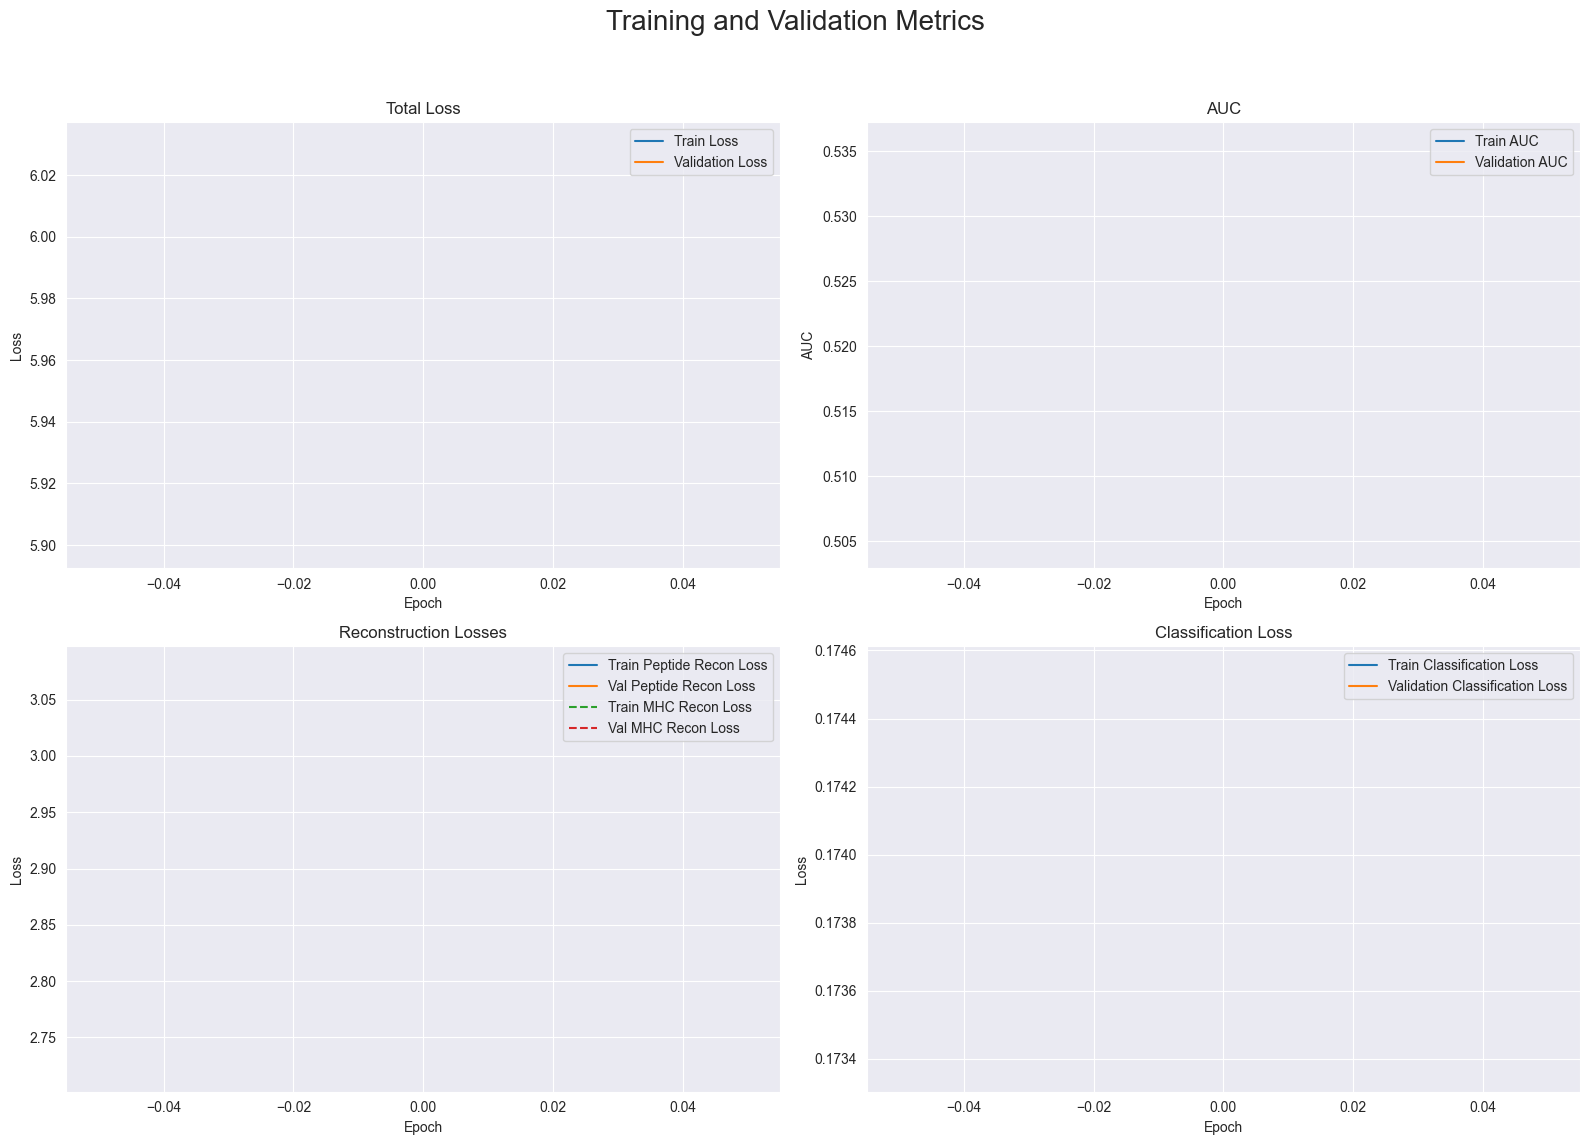

Training history plots generated.


/Users/amirreza/miniforge3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating UMAP of latent space...
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0.0406171195 0.119045034 0.0625185668 ... 0.0538002402 0.0768636242 0.020700857]
 [0.0448468626 0.113437817 0.0732050538 ... 0.0671016872 0.0602467731 0.0327793546]
 [0.0530254 0.126695693 0.0716531277 ... 0.0562132597 0.0604988821 0.0269627366]
 ...
 [0.0417282246 0.113329574 0.0730792359 ... 0.0577020049 0.0835079476 0.0229248255]
 [0.0342846625 0.120483592 0.0468621626 ... 0.063078478 0.0864595175 0.0288141835]
 [0.0310577936 0.0979611129 0.0746048167 ... 0.0568239093 0.0847346187 0.031619858]]
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0.0299171545 0.100724474 0.0595269464 ... 0.0595529415 0.099188216 0.0327796079]
 [0.0385176651 0.122511387 0.0635183454 ... 0.0649032593 0.0668953285 0.0295141339]
 [0.041043777 0.114049837 0.0724455938 ... 0.0581836328 0.084253706 0.0230968576]
 ...
 [0.0333727561 0.105665334 0.0468882807 ... 0.0516759269 0.098578095

/Users/amirreza/miniforge3/envs/py312/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


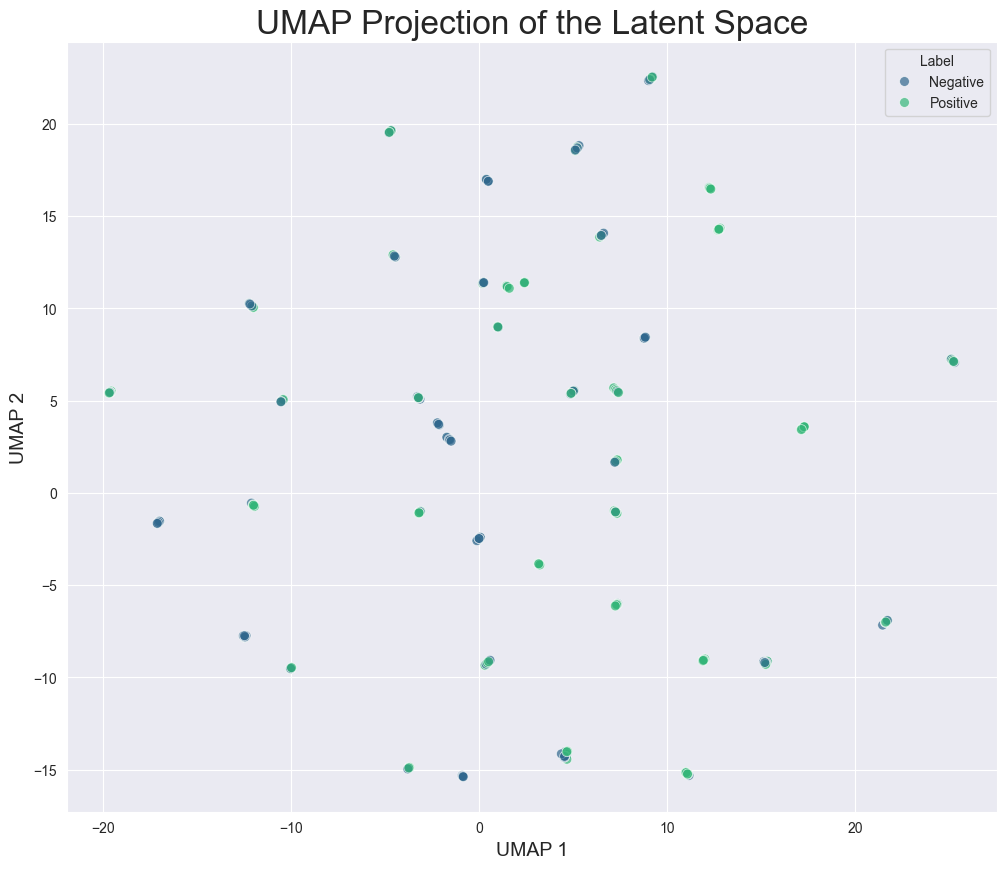

UMAP plot generated.
Visualizing expert activations...
Gate probabilities shape: TensorShape([128, 16]) Gate probabilities: [[0.0488454439 0.116878234 0.077696465 ... 0.050113745 0.060830649 0.0265255738]
 [0.0491790101 0.115001217 0.0734945 ... 0.0513746552 0.0865111947 0.0268353801]
 [0.0381142385 0.126544431 0.0611386709 ... 0.064759694 0.0708382204 0.028411461]
 ...
 [0.0420087948 0.113172404 0.0737855 ... 0.0581213646 0.0833750889 0.0234673359]
 [0.0428485833 0.078228943 0.082427226 ... 0.0570197776 0.0792907476 0.0359614901]
 [0.0329009257 0.118908934 0.0545527041 ... 0.064478904 0.0807935074 0.0273209456]]


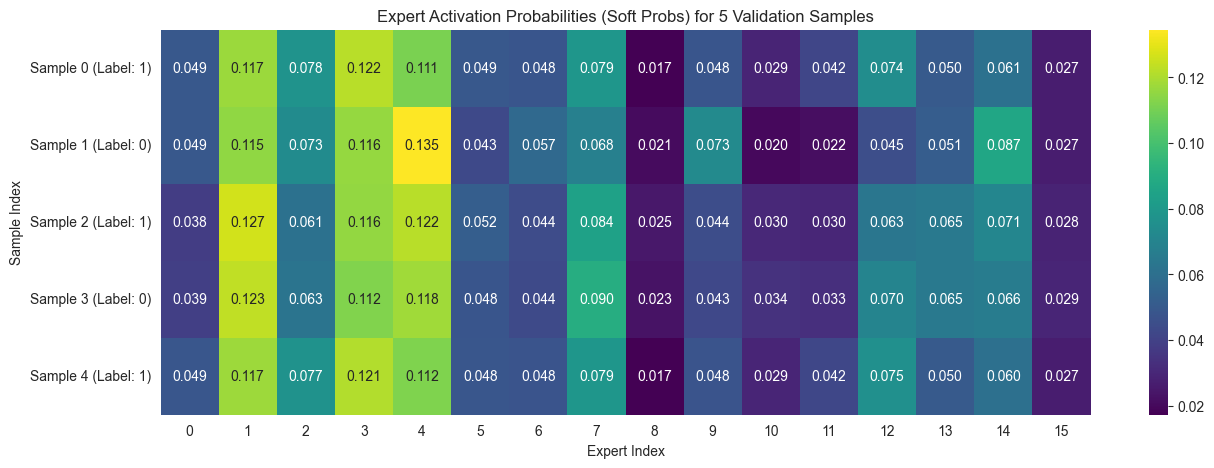

Expert activation plot generated.


In [33]:
# ==============================================================================
# 7. PLOT TRAINING HISTORY
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("Plotting training history...")

# Create a dataframe from history for easier plotting
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training and Validation Metrics', fontsize=20)

# Plot Total Loss
axes[0, 0].plot(history_df.index, history_df['loss'], label='Train Loss')
axes[0, 0].plot(history_df.index, history_df['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot AUC
axes[0, 1].plot(history_df.index, history_df['auc'], label='Train AUC')
axes[0, 1].plot(history_df.index, history_df['val_auc'], label='Validation AUC')
axes[0, 1].set_title('AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Reconstruction Losses
axes[1, 0].plot(history_df.index, history_df['pep_recon_loss'], label='Train Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['val_pep_recon_loss'], label='Val Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['mhc_recon_loss'], label='Train MHC Recon Loss', linestyle='--')
axes[1, 0].plot(history_df.index, history_df['val_mhc_recon_loss'], label='Val MHC Recon Loss', linestyle='--')
axes[1, 0].set_title('Reconstruction Losses')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Classification Loss
axes[1, 1].plot(history_df.index, history_df['class_loss'], label='Train Classification Loss')
axes[1, 1].plot(history_df.index, history_df['val_class_loss'], label='Validation Classification Loss')
axes[1, 1].set_title('Classification Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Training history plots generated.")

# ==============================================================================
# 8. UMAP VISUALIZATION OF LATENT SPACE
# ==============================================================================
# !pip install umap-learn seaborn
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating UMAP of latent space...")

# --- Get latent vectors and labels from the validation set ---
latent_vectors = []
true_labels = []
all_soft_probs = []

for x_val_batch, y_val_batch in val_dataset:
    x_batch_list = [
        x_val_batch['pep_onehot'],
        x_val_batch['pep_mask'],
        x_val_batch['mhc_emb'],
        x_val_batch['mhc_mask'],
        x_val_batch['mhc_onehot']
    ]
    predictions = model(x_batch_list, training=False)
    latent_vectors.append(predictions['latent_vector'].numpy())
    true_labels.append(y_val_batch['cls_ypred'].numpy())
    all_soft_probs.append(predictions['soft_cluster_probs'].numpy())

# Concatenate all batches
latent_vectors = np.concatenate(latent_vectors, axis=0)
true_labels = np.concatenate(true_labels, axis=0).flatten()
all_soft_probs = np.concatenate(all_soft_probs, axis=0)

# --- Run UMAP ---
# Note: umap-learn needs to be installed (`pip install umap-learn`)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# --- Plot UMAP ---
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=true_labels,
    palette=sns.color_palette("viridis", 2),
    alpha=0.7,
    s=50
)
plt.title('UMAP Projection of the Latent Space', fontsize=24)
plt.xlabel("UMAP 1", fontsize=14)
plt.ylabel("UMAP 2", fontsize=14)
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles, ['Negative', 'Positive'], title='Label')
plt.grid(True)
plt.show()

print("UMAP plot generated.")
# ==============================================================================
# 9. VISUALIZE EXPERT ACTIVATIONS
# ==============================================================================
print("Visualizing expert activations...")

# --- Get soft probabilities from the first validation batch ---
for x_val_batch, y_val_batch in val_dataset.take(1):
    x_batch_list = [
        x_val_batch['pep_onehot'],
        x_val_batch['pep_mask'],
        x_val_batch['mhc_emb'],
        x_val_batch['mhc_mask'],
        x_val_batch['mhc_onehot']
    ]
    predictions = model(x_batch_list, training=False)
    soft_probs = predictions['soft_cluster_probs'].numpy()
    sample_labels = y_val_batch['cls_ypred'].numpy().flatten()

# Take the first 5 samples for visualization
sample_probs = soft_probs[:5]
sample_labels_5 = sample_labels[:5]

# --- Plot heatmap of expert activations ---
plt.figure(figsize=(15, 5))
sns.heatmap(sample_probs, annot=True, cmap='viridis', fmt='.3f',
            yticklabels=[f"Sample {i} (Label: {int(l)})" for i, l in enumerate(sample_labels_5)])
plt.title('Expert Activation Probabilities (Soft Probs) for 5 Validation Samples')
plt.xlabel('Expert Index')
plt.ylabel('Sample Index')
plt.show()

print("Expert activation plot generated.")

# ==============================================================================
# 10. VISUALIZE OVERALL EXPERT UTILIZATION
# ==============================================================================
print("Visualizing overall expert utilization...")

# --- Calculate total activation for each expert ---
# Sum probabilities for each expert across all validation samples
expert_utilization = np.sum(all_soft_probs, axis=0)

# --- Plot bar chart of expert utilization ---
plt.figure(figsize=(18, 7))
expert_indices = np.arange(num_experts)
plt.bar(expert_indices, expert_utilization, color='skyblue')
plt.title('Total Expert Utilization Across Validation Set', fontsize=18)
plt.xlabel('Expert Index', fontsize=14)
plt.ylabel('Sum of Soft Probabilities (Activation)', fontsize=14)
plt.xticks(expert_indices)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Expert utilization plot generated.")

In [34]:
# ==============================================================================
